In [17]:
# Import Pustaka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from tensorflow.keras import layers, callbacks, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve, # <-- Ditambahkan
    auc                     # <-- Ditambahkan
)

In [18]:
class DataManager:
    """Mengelola pemuatan, prapemrosesan, dan penskalaan data."""
    def __init__(self, file_path, test_size=0.2, random_state=42):
        self.df = pd.read_csv(file_path)
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self._prepare_data()

    def _prepare_data(self):
        """Memproses data: membagi, SMOTE, dan penskalaan."""
        # 1. Pisahkan fitur (X) dan target (y)
        X = self.df.drop(columns=['Class'])
        y = self.df['Class']

        # 2. Bagi data menjadi set pelatihan dan pengujian
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, stratify=y, random_state=self.random_state
        )

        # 3. Terapkan SMOTE pada data pelatihan
        smote = SMOTE(random_state=self.random_state)
        self.X_train_res, self.y_train_res = smote.fit_resample(self.X_train, self.y_train)

        # 4. Skalakan fitur
        self.X_train_scaled = self.scaler.fit_transform(self.X_train_res)
        self.X_test_scaled = self.scaler.transform(self.X_test)

    def get_tensorflow_data(self):
        return self.X_train_scaled, self.X_test_scaled, self.y_train_res, self.y_test

    def get_pytorch_data(self):
        """Mengonversi data ke format tensor PyTorch."""
        X_train_t = torch.tensor(self.X_train_scaled, dtype=torch.float32)
        y_train_t = torch.tensor(self.y_train_res.values, dtype=torch.float32).view(-1, 1)
        X_test_t = torch.tensor(self.X_test_scaled, dtype=torch.float32)
        y_test_t = torch.tensor(self.y_test.values, dtype=torch.float32).view(-1, 1)
        return X_train_t, X_test_t, y_train_t, y_test_t

In [19]:
def plot_training_history(history_tf, history_pt, epochs_pt):
    """Membuat plot perbandingan riwayat pelatihan loss dan akurasi."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Training & Validation Loss
    ax[0].plot(history_tf.history['loss'], label='TF Train Loss', color='blue')
    ax[0].plot(history_tf.history['val_loss'], label='TF Val Loss', color='cyan', linestyle='--')
    ax[0].plot(range(epochs_pt), history_pt['train_loss'], label='PyTorch Train Loss', color='purple')
    ax[0].plot(range(epochs_pt), history_pt['val_loss'], label='PyTorch Val Loss', color='magenta', linestyle='--')
    ax[0].set_title('Perbandingan Training & Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot Training & Validation Accuracy
    ax[1].plot(history_tf.history['accuracy'], label='TF Train Accuracy', color='blue')
    ax[1].plot(history_tf.history['val_accuracy'], label='TF Val Accuracy', color='cyan', linestyle='--')
    ax[1].plot(range(epochs_pt), history_pt['train_acc'], label='PyTorch Train Accuracy', color='purple')
    ax[1].plot(range(epochs_pt), history_pt['val_acc'], label='PyTorch Val Accuracy', color='magenta', linestyle='--')
    ax[1].set_title('Perbandingan Training & Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

def plot_comparison_curves(eval_results):
    """Membuat plot perbandingan kurva ROC dan Precision-Recall."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Kurva ROC
    for name, data in eval_results.items():
        fpr, tpr, _ = roc_curve(data['y_true'], data['y_prob'])
        auc_score = roc_auc_score(data['y_true'], data['y_prob'])
        ax[0].plot(fpr, tpr, label=f"{name} AUC = {auc_score:.4f}")

    ax[0].plot([0, 1], [0, 1], 'k--', label='Garis Acak')
    ax[0].set_title('Perbandingan Kurva ROC Antar Model')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend()

    # Plot Kurva Precision-Recall
    for name, data in eval_results.items():
        precision, recall, _ = precision_recall_curve(data['y_true'], data['y_prob'])
        pr_auc = auc(recall, precision)
        ax[1].plot(recall, precision, label=f"{name} PR AUC = {pr_auc:.4f}")

    ax[1].set_title('Perbandingan Kurva Precision-Recall Antar Model')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred, title, cmap):
    """Membuat plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(title)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

In [20]:
class MLPTensorFlow:
    """Membangun, melatih, dan mengevaluasi model MLP dengan TensorFlow/Keras."""
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_shape,)),
            layers.BatchNormalization(), layers.Dropout(0.3),
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=512, validation_split=0.2):
        early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                 validation_split=validation_split, callbacks=[early_stop], verbose=1)
        return history

    def evaluate(self, X_test, y_test):
        """Mengevaluasi model dan mengembalikan hasil untuk perbandingan."""
        y_pred_prob = self.model.predict(X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        print("\nLaporan Klasifikasi Model MLP dengan TensorFlow/Keras:")
        print(classification_report(y_test, y_pred))
        
        plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - TensorFlow/Keras", "Blues")

        return {'y_true': y_test, 'y_prob': y_pred_prob, 'y_pred': y_pred}

In [21]:
class MLPPyTorch:
    """Membangun, melatih, dan mengevaluasi model MLP dengan PyTorch."""
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, 64), nn.ReLU(),
                nn.Linear(64, 1), nn.Sigmoid()
            )
        def forward(self, x): return self.net(x)

    def __init__(self, input_dim):
        self.model = self.MLP(input_dim)
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)

    def train(self, X_train_t, y_train_t, epochs=10, batch_size=512, validation_split=0.2):
        # Bagi data latih menjadi latih dan validasi
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(
            X_train_t, y_train_t, test_size=validation_split, random_state=42
        )
        
        train_loader = DataLoader(TensorDataset(X_train_sub, y_train_sub), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(epochs):
            self.model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for xb, yb in train_loader:
                pred = self.model(xb)
                loss = self.criterion(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                train_correct += ((pred > 0.5).float() == yb).sum().item()
                train_total += yb.size(0)
            
            history['train_loss'].append(train_loss / len(train_loader))
            history['train_acc'].append(train_correct / train_total)

            self.model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for xb_val, yb_val in val_loader:
                    pred_val = self.model(xb_val)
                    val_loss += self.criterion(pred_val, yb_val).item()
                    val_correct += ((pred_val > 0.5).float() == yb_val).sum().item()
                    val_total += yb_val.size(0)
            
            history['val_loss'].append(val_loss / len(val_loader))
            history['val_acc'].append(val_correct / val_total)
            
            print(f"Epoch {epoch+1}/{epochs} -> "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_acc'][-1]:.4f} | "
                  f"Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")
        return history

    def evaluate(self, X_test_t, y_test):
        self.model.eval()
        with torch.no_grad():
            y_pred_prob = self.model(X_test_t).numpy().flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
        
        print("\nLaporan Klasifikasi Model MLP dengan PyTorch:")
        print(classification_report(y_test, y_pred))
        
        plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - PyTorch", "Purples")
        
        return {'y_true': y_test, 'y_prob': y_pred_prob, 'y_pred': y_pred}

===== Memulai Pelatihan & Evaluasi TensorFlow =====
Epoch 1/50
711/711 [==============================] - 3s 3ms/step - loss: 0.1770 - accuracy: 0.9798 - precision_3: 0.9865 - recall_3: 0.9594 - val_loss: 0.0297 - val_accuracy: 0.9912 - val_precision_3: 1.0000 - val_recall_3: 0.9912
Epoch 2/50
711/711 [==============================] - 2s 2ms/step - loss: 0.0321 - accuracy: 0.9914 - precision_3: 0.9916 - recall_3: 0.9855 - val_loss: 0.0315 - val_accuracy: 0.9896 - val_precision_3: 1.0000 - val_recall_3: 0.9896
Epoch 3/50
711/711 [==============================] - 2s 2ms/step - loss: 0.0228 - accuracy: 0.9942 - precision_3: 0.9936 - recall_3: 0.9910 - val_loss: 0.0156 - val_accuracy: 0.9970 - val_precision_3: 1.0000 - val_recall_3: 0.9970
Epoch 4/50
711/711 [==============================] - 2s 2ms/step - loss: 0.0183 - accuracy: 0.9956 - precision_3: 0.9946 - recall_3: 0.9936 - val_loss: 0.0139 - val_accuracy: 0.9979 - val_precision_3: 1.0000 - val_recall_3: 0.9979
Epoch 5/50
711/711 [

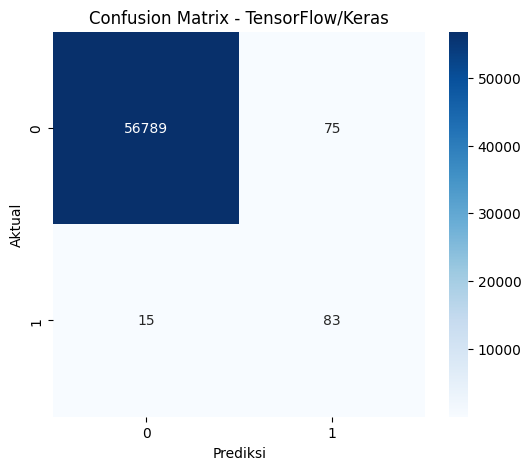



===== Memulai Pelatihan & Evaluasi PyTorch =====
Epoch 1/10 -> Train Loss: 0.0832, Train Acc: 0.9721 | Val Loss: 0.0258, Val Acc: 0.9927
Epoch 2/10 -> Train Loss: 0.0341, Train Acc: 0.9904 | Val Loss: 0.0156, Val Acc: 0.9967
Epoch 3/10 -> Train Loss: 0.0267, Train Acc: 0.9935 | Val Loss: 0.0117, Val Acc: 0.9980
Epoch 4/10 -> Train Loss: 0.0215, Train Acc: 0.9953 | Val Loss: 0.0099, Val Acc: 0.9982
Epoch 5/10 -> Train Loss: 0.0201, Train Acc: 0.9959 | Val Loss: 0.0086, Val Acc: 0.9990
Epoch 6/10 -> Train Loss: 0.0187, Train Acc: 0.9963 | Val Loss: 0.0084, Val Acc: 0.9989
Epoch 7/10 -> Train Loss: 0.0173, Train Acc: 0.9970 | Val Loss: 0.0077, Val Acc: 0.9989
Epoch 8/10 -> Train Loss: 0.0160, Train Acc: 0.9972 | Val Loss: 0.0072, Val Acc: 0.9991
Epoch 9/10 -> Train Loss: 0.0153, Train Acc: 0.9976 | Val Loss: 0.0069, Val Acc: 0.9992
Epoch 10/10 -> Train Loss: 0.0140, Train Acc: 0.9977 | Val Loss: 0.0063, Val Acc: 0.9993

Laporan Klasifikasi Model MLP dengan PyTorch:
              precisi

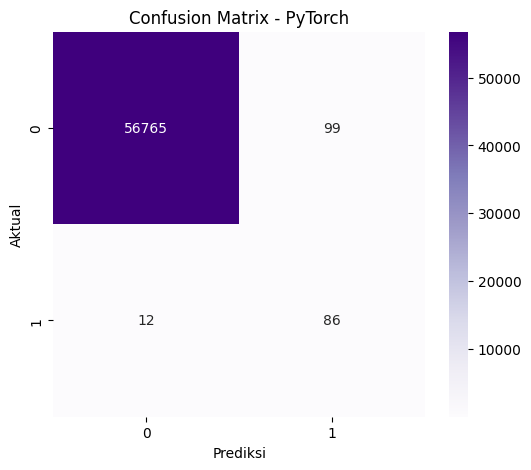



===== Visualisasi Perbandingan Antar Model =====


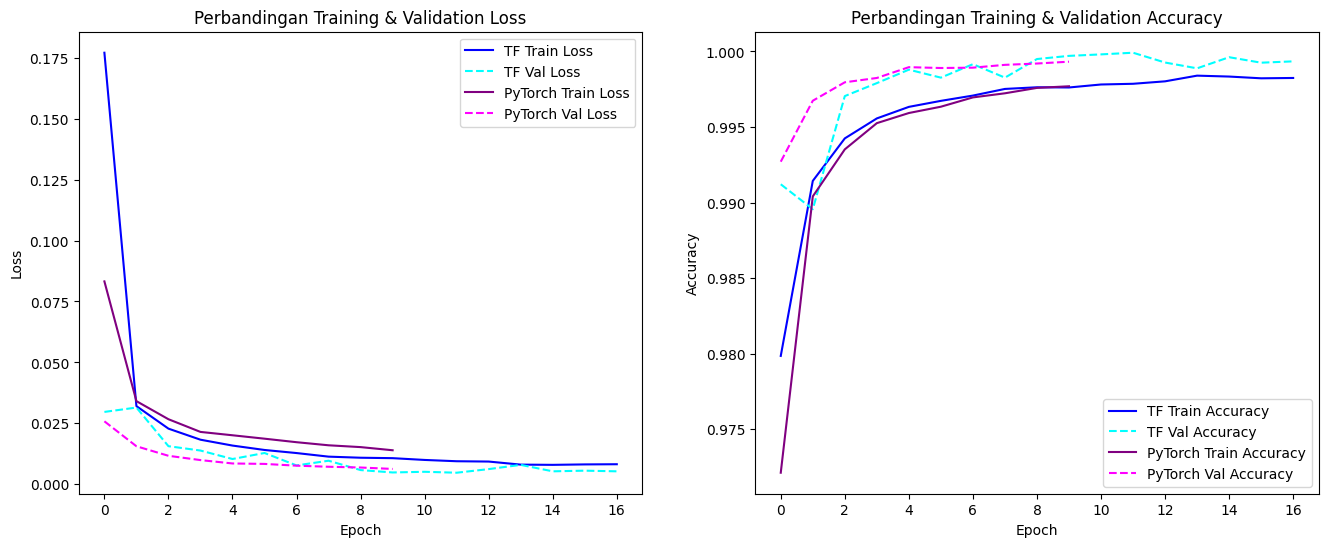

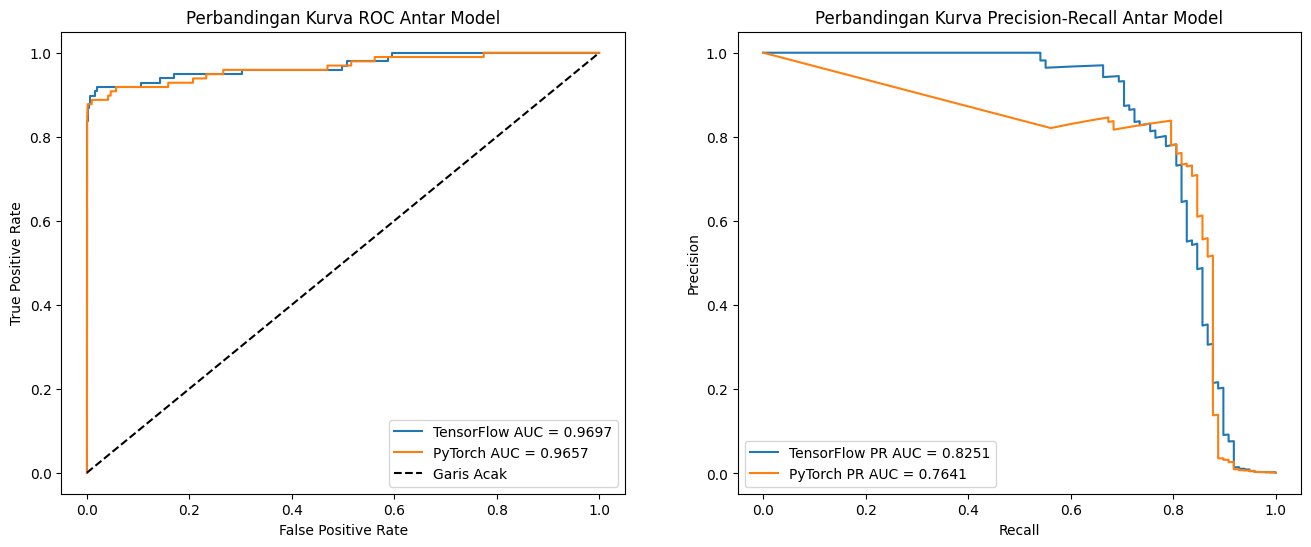

In [22]:
# --- 1. Inisialisasi dan Prapemrosesan Data ---
file_path = 'KlasifikasiUTS.csv'
data_manager = DataManager(file_path)

# --- 2. Model TensorFlow ---
print("===== Memulai Pelatihan & Evaluasi TensorFlow =====")
X_train_tf, X_test_tf, y_train_tf, y_test_tf = data_manager.get_tensorflow_data()
tf_model_wrapper = MLPTensorFlow(input_shape=X_train_tf.shape[1])
history_tf = tf_model_wrapper.train(X_train_tf, y_train_tf)
eval_tf = tf_model_wrapper.evaluate(X_test_tf, y_test_tf)

# --- 3. Model PyTorch ---
print("\n\n===== Memulai Pelatihan & Evaluasi PyTorch =====")
X_train_pt, X_test_pt, y_train_pt, y_test_pt = data_manager.get_pytorch_data()
pt_epochs = 10 # PyTorch butuh lebih sedikit epoch untuk konvergen dalam kasus ini
pt_model_wrapper = MLPPyTorch(input_dim=X_train_pt.shape[1])
history_pt = pt_model_wrapper.train(X_train_pt, y_train_pt, epochs=pt_epochs)
eval_pt = pt_model_wrapper.evaluate(X_test_pt, data_manager.y_test)

# --- 4. Visualisasi Perbandingan ---
print("\n\n===== Visualisasi Perbandingan Antar Model =====")
plot_training_history(history_tf, history_pt, pt_epochs)

all_evals = {
    "TensorFlow": eval_tf,
    "PyTorch": eval_pt
}
plot_comparison_curves(all_evals)